# 🧪 Advanced: BEATs Feature Extraction Analysis

> **Note**: This is the comprehensive, advanced version of the feature extraction tutorial.
> 
> **New to BEATs?** Try the simplified version first: [`Quick_Start_Feature_Extraction.ipynb`](Quick_Start_Feature_Extraction.ipynb)

This notebook provides an in-depth analysis of BEATs feature extraction with:
- Detailed model comparisons
- Advanced visualizations (PCA, t-SNE, UMAP)
- Quantitative evaluation metrics
- Research-grade analysis techniques

**Estimated time**: 45-60 minutes | **Level**: Advanced

# BEATs Feature Extraction and Comparison

This notebook demonstrates how to use the BEATs feature extractor to extract and visualize embeddings from the ESC-50 dataset. We'll compare embeddings from:

1. **Pre-trained BEATs**: The original model trained on AudioSet
2. **Fine-tuned BEATs**: Model fine-tuned specifically on ESC-50 data

## Key Learning Objectives
- Learn how to use the `BEATsFeatureExtractor` class
- Extract high-quality audio embeddings for downstream tasks
- Compare pre-trained vs fine-tuned model representations
- Visualize audio embeddings using dimensionality reduction
- Quantify representation quality with metrics

## 1. Import Required Libraries

Let's import all the necessary libraries for feature extraction, visualization, and analysis.

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import umap

warnings.filterwarnings("ignore")

# Machine learning libraries
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Import the feature extractor
from beats_trainer import BEATsFeatureExtractor

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

print("All libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

%load_ext autoreload
%autoreload 2

All libraries imported successfully!
Current working directory: /home/benjamin.cretois/Code/BEATs_on_ESC50/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Demonstrate automatic checkpoint download
try:
    from beats_trainer import list_available_models, ensure_checkpoint

    print("🔍 Available BEATs models:")
    models = list_available_models()
    for name, info in models.items():
        print(f"  • {name}: {info['description']} (~{info['size_mb']} MB)")

    print("\n📦 Ensuring BEATs checkpoint is available...")
    checkpoint_path = ensure_checkpoint()

    if checkpoint_path:
        print(f"✅ Checkpoint ready at: {checkpoint_path}")
        print(f"   File size: {checkpoint_path.stat().st_size / (1024 * 1024):.1f} MB")
    else:
        print("⚠️  Could not ensure checkpoint is available")

except ImportError as e:
    print(f"⚠️  Could not import checkpoint utilities: {e}")
    print("This might happen if the beats_trainer module is not properly installed.")

except Exception as e:
    print(f"⚠️  Error with checkpoint management: {e}")
    print("Will proceed with manual checkpoint path specification in the next cells.")

🔍 Available BEATs models:
  • BEATs_iter3_plus_AS2M: BEATs model trained on AudioSet with 2M iterations (~110 MB)

📦 Ensuring BEATs checkpoint is available...
🔍 No existing checkpoint found, downloading BEATs_iter3_plus_AS2M...
📥 Downloading BEATs_iter3_plus_AS2M...
Description: BEATs model trained on AudioSet with 2M iterations
Expected size: ~110 MB
Saving to: /home/benjamin.cretois/Code/BEATs_on_ESC50/notebooks/checkpoints/BEATs_iter3_plus_AS2M.pt

Progress: 100.0% (344.8 MB)
✓ Download complete: /tmp/tmp4_2z1gab.tmp
🎉 Successfully downloaded BEATs_iter3_plus_AS2M!
✓ Checkpoint ready at: /home/benjamin.cretois/Code/BEATs_on_ESC50/notebooks/checkpoints/BEATs_iter3_plus_AS2M.pt


## 2. Load ESC-50 Dataset

We'll load the ESC-50 dataset metadata and organize the audio files by class for feature extraction.

In [8]:
# Define paths to datasets
esc50_raw_path = Path("ESC-50-master")
esc50_organized_path = Path("ESC50_organized")
audio_dir = esc50_raw_path / "audio"
meta_file = esc50_raw_path / "meta" / "esc50.csv"

# Check if dataset exists
if not esc50_raw_path.exists():
    print(
        "⚠️  ESC-50 dataset not found. Please run the main fine-tuning notebook first to download the data."
    )
    print("Expected path:", esc50_raw_path.absolute())
    print("\n🎯 Creating demo data instead...")

    # Create demo metadata for testing
    import numpy as np

    np.random.seed(42)

    # Create fake metadata that resembles ESC-50 structure
    demo_classes = [
        "dog",
        "cat",
        "rain",
        "bird",
        "car_horn",
        "footsteps",
        "knock",
        "bell",
    ]
    demo_data = []

    for i, class_name in enumerate(demo_classes):
        for j in range(5):  # 5 samples per class for demo
            demo_data.append(
                {
                    "filename": f"{i:03d}-{j}-{class_name}.wav",
                    "category": class_name,
                    "fold": np.random.randint(1, 6),
                }
            )

    metadata = pd.DataFrame(demo_data)
    sampled_metadata = metadata.copy()  # Use all demo data

    # Note: These files don't actually exist, but we'll handle that in the extractor
    sampled_metadata["file_path"] = sampled_metadata["filename"].apply(
        lambda x: Path("demo_audio") / x  # Fake path
    )

    print(
        f"📊 Created demo dataset with {len(sampled_metadata)} samples across {len(demo_classes)} classes"
    )
    print("Classes:", demo_classes)
    print(
        "\n⚠️  Note: These are fake file paths for demonstration. Feature extraction will be skipped."
    )

else:
    print(f"✓ Found ESC-50 dataset at: {esc50_raw_path.absolute()}")

    # Load metadata
    if meta_file.exists():
        metadata = pd.read_csv(meta_file)
        print(f"Loaded metadata with {len(metadata)} samples")
        print(
            f"Classes: {metadata['category'].nunique()} ({metadata['category'].unique()[:5]}...)"
        )
        print("Dataset overview:")
        print(metadata.head())

        # Create sample selection (limit to reasonable number for visualization)
        # Take a subset for faster processing - you can increase this
        n_samples_per_class = 20  # Adjust this number based on your needs

        sampled_metadata = metadata.groupby("category").head(n_samples_per_class)
        print(
            f"\nSelected {len(sampled_metadata)} samples ({n_samples_per_class} per class) for feature extraction"
        )

        # Create file paths
        sampled_metadata["file_path"] = sampled_metadata["filename"].apply(
            lambda x: audio_dir / x
        )

        # Verify files exist
        existing_files = sampled_metadata["file_path"].apply(lambda x: x.exists())
        sampled_metadata = sampled_metadata[existing_files]

        print(f"Found {len(sampled_metadata)} existing audio files")
        print("Classes distribution:")
        print(sampled_metadata["category"].value_counts().head(10))

    else:
        print("Metadata file not found!")

print("\n✅ Dataset preparation complete!")
print(f"   Samples: {len(sampled_metadata) if 'sampled_metadata' in locals() else 0}")
print(
    f"   Classes: {sampled_metadata['category'].nunique() if 'sampled_metadata' in locals() else 0}"
)

✓ Found ESC-50 dataset at: /home/benjamin.cretois/Code/BEATs_on_ESC50/notebooks/ESC-50-master
Loaded metadata with 2000 samples
Classes: 50 (['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock']...)
Dataset overview:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Selected 1000 samples (20 per class) for feature extraction
Found 1000 existing audio files
Classes distribution:
category
dog                20
chirping_birds     20
vacuum_cleaner     20
thunderstorm       20
door_wood_knock    20
can_opening        20
crow               20
clapping           20
fireworks          20
ch

## 3. Initialize Feature Extractors

We'll create two feature extractors:
1. **Pretrained BEATs**: Using the original AudioSet-trained model
2. **Fine-tuned BEATs**: Using a model fine-tuned on ESC-50 (if available)

In [9]:
# Initialize extractors using the new automatic checkpoint management

# Method 1: Use automatic checkpoint discovery/download
print("🔧 Initializing extractors with automatic checkpoint management...")

extractors = {}

# 1. Pretrained BEATs extractor (automatic)
print("Initializing pretrained BEATs feature extractor...")
try:
    extractors["pretrained"] = BEATsFeatureExtractor(
        model_path=None,  # Will auto-find or download
        pooling="mean",
        device="auto",
    )
    print("✓ Pretrained BEATs extractor ready (automatic checkpoint)")
except Exception as e:
    print(f"⚠️  Could not initialize automatic extractor: {e}")

# 2. Look for fine-tuned models in logs directory
finetuned_model_path = None
logs_dir = Path("../logs")
if logs_dir.exists():
    checkpoint_files = list(logs_dir.rglob("*.ckpt"))
    if checkpoint_files:
        # Sort by modification time and get the most recent
        finetuned_model_path = sorted(
            checkpoint_files, key=lambda x: x.stat().st_mtime
        )[-1]
        print(f"Found fine-tuned model: {finetuned_model_path}")

        try:
            extractors["finetuned"] = BEATsFeatureExtractor(
                model_path=finetuned_model_path, pooling="mean", device="auto"
            )
            print("✓ Fine-tuned BEATs extractor ready")
        except Exception as e:
            print(f"⚠️  Could not load fine-tuned model: {e}")
    else:
        print("No fine-tuned model checkpoints found in logs directory")

# 3. If no fine-tuned model, create extractors with different pooling for comparison
if "finetuned" not in extractors and "pretrained" in extractors:
    print(
        "\nCreating additional extractors with different pooling methods for comparison..."
    )
    try:
        extractors["pretrained_max"] = BEATsFeatureExtractor(
            model_path=None,  # Will reuse the same downloaded checkpoint
            pooling="max",
            device="auto",
        )
        print("✓ Added pretrained BEATs with max pooling")
    except Exception as e:
        print(f"⚠️  Could not create max pooling extractor: {e}")

print(f"\nAvailable extractors: {list(extractors.keys())}")

# Show which checkpoint each extractor is using
for name, extractor in extractors.items():
    print(f"  {name}: {extractor.model_path.name}")

print("\n🎉 Extractor initialization complete! No manual downloads needed.")

🔧 Initializing extractors with automatic checkpoint management...
Initializing pretrained BEATs feature extractor...
No model path specified, attempting to find or download BEATs checkpoint...
✓ Found existing checkpoint: /home/benjamin.cretois/Code/BEATs_on_ESC50/notebooks/checkpoints/BEATs_iter3_plus_AS2M.pt
Loaded BEATs model with 12 layers
Feature dimension: 768
Device: cuda
✓ Pretrained BEATs extractor ready (automatic checkpoint)

Creating additional extractors with different pooling methods for comparison...
No model path specified, attempting to find or download BEATs checkpoint...
✓ Found existing checkpoint: /home/benjamin.cretois/Code/BEATs_on_ESC50/notebooks/checkpoints/BEATs_iter3_plus_AS2M.pt
Loaded BEATs model with 12 layers
Feature dimension: 768
Device: cuda
✓ Pretrained BEATs extractor ready (automatic checkpoint)

Creating additional extractors with different pooling methods for comparison...
No model path specified, attempting to find or download BEATs checkpoint...

## 4. Extract Features from Audio Files

Now we'll extract embeddings from the selected ESC-50 audio files using both extractors.

In [10]:
# Extract features using each extractor
features = {}
labels = []
audio_files = []

if "sampled_metadata" in locals() and len(extractors) > 0:
    # Get file paths and labels
    file_paths = sampled_metadata["file_path"].tolist()
    labels = sampled_metadata["category"].tolist()
    audio_files = sampled_metadata["filename"].tolist()

    # Check if we actually have real audio files
    real_files = [p for p in file_paths if p.exists()]

    if len(real_files) == 0:
        print(
            "⚠️  No actual audio files found. Creating synthetic features for demonstration..."
        )

        # Create synthetic features that resemble what BEATs would produce
        import numpy as np

        np.random.seed(42)

        n_samples = len(file_paths)
        feature_dim = 768  # BEATs feature dimension

        # Create class-dependent synthetic features
        unique_labels = list(set(labels))
        label_to_idx = {label: i for i, label in enumerate(unique_labels)}

        for extractor_name, extractor in extractors.items():
            print(f"Creating synthetic features for {extractor_name}...")

            synthetic_features = []
            for label in labels:
                # Create features that cluster by class
                class_idx = label_to_idx[label]
                base_vector = np.random.randn(feature_dim) * 0.1
                base_vector[class_idx * 10 : (class_idx + 1) * 10] += (
                    2.0  # Make classes separable
                )

                # Add some noise
                noise = np.random.randn(feature_dim) * 0.2
                feature_vector = base_vector + noise

                # Normalize as BEATs features typically are
                feature_vector = feature_vector / np.linalg.norm(feature_vector)
                synthetic_features.append(feature_vector)

            synthetic_array = np.array(synthetic_features)
            features[extractor_name] = synthetic_array

            print(
                f"✓ {extractor_name}: created {synthetic_array.shape} synthetic features"
            )
            print(
                f"  Feature statistics - Mean: {synthetic_array.mean():.4f}, Std: {synthetic_array.std():.4f}"
            )

        print(
            "\n📝 Note: Using synthetic features for demonstration since no real audio files were found."
        )
        print("   In a real scenario, make sure to download the ESC-50 dataset first.")

    else:
        print(f"Extracting features from {len(real_files)} audio files...")

        # Use only the files that actually exist
        valid_indices = [i for i, p in enumerate(file_paths) if p.exists()]
        valid_file_paths = [file_paths[i] for i in valid_indices]
        valid_labels = [labels[i] for i in valid_indices]
        valid_audio_files = [audio_files[i] for i in valid_indices]

        # Update our variables to only include valid samples
        labels = valid_labels
        audio_files = valid_audio_files

        # Extract features with each extractor
        for extractor_name, extractor in extractors.items():
            print(f"\nExtracting features using {extractor_name} extractor...")

            try:
                # Extract features in batches for efficiency
                batch_features = extractor.extract_from_files(
                    valid_file_paths,
                    batch_size=8,  # Adjust based on your GPU memory
                    normalize=True,
                )

                features[extractor_name] = batch_features
                print(f"✓ {extractor_name}: extracted {batch_features.shape} features")
                print(
                    f"  Feature statistics - Mean: {batch_features.mean():.4f}, Std: {batch_features.std():.4f}"
                )

            except Exception as e:
                print(f"⚠️  Error extracting features with {extractor_name}: {e}")

    if features:  # Only proceed if we have features (real or synthetic)
        # Encode labels for consistency
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        unique_classes = label_encoder.classes_

        print("\n✅ Feature extraction complete!")
        print(f"   Samples processed: {len(labels)}")
        print(
            f"   Classes: {len(unique_classes)} ({list(unique_classes[:5])}{'...' if len(unique_classes) > 5 else ''})"
        )
        print(f"   Feature shape per extractor: {list(features.values())[0].shape}")

    else:
        print("❌ No features were extracted!")

elif len(extractors) == 0:
    print(
        "⚠️  No extractors available! Check the previous cell for initialization errors."
    )

else:
    print("⚠️  No metadata loaded! Check the dataset loading cell.")

Extracting features from 1000 audio files...

Extracting features using pretrained extractor...
✓ pretrained: extracted (1000, 768) features
  Feature statistics - Mean: 0.0002, Std: 0.0361

Extracting features using pretrained_max extractor...
✓ pretrained: extracted (1000, 768) features
  Feature statistics - Mean: 0.0002, Std: 0.0361

Extracting features using pretrained_max extractor...
✓ pretrained_max: extracted (1000, 768) features
  Feature statistics - Mean: 0.0333, Std: 0.0139

✅ Feature extraction complete!
   Samples processed: 1000
   Classes: 50 ([np.str_('airplane'), np.str_('breathing'), np.str_('brushing_teeth'), np.str_('can_opening'), np.str_('car_horn')]...)
   Feature shape per extractor: (1000, 768)
✓ pretrained_max: extracted (1000, 768) features
  Feature statistics - Mean: 0.0333, Std: 0.0139

✅ Feature extraction complete!
   Samples processed: 1000
   Classes: 50 ([np.str_('airplane'), np.str_('breathing'), np.str_('brushing_teeth'), np.str_('can_opening'), n

## 5. Reduce Dimensionality for Visualization

To visualize the high-dimensional embeddings, we'll use dimensionality reduction techniques like t-SNE and UMAP.

In [19]:
# Apply dimensionality reduction to extracted features
reduced_features = {}

if features:
    for extractor_name, feature_array in features.items():
        print(f"\nApplying dimensionality reduction to {extractor_name} features...")
        print(f"Original shape: {feature_array.shape}")

        reduced_features[extractor_name] = {}

        # t-SNE
        print("  Applying t-SNE...")
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(
                30, len(feature_array) - 1
            ),  # Adjust perplexity if we have few samples
            max_iter=1000,
        )
        tsne_result = tsne.fit_transform(feature_array)
        reduced_features[extractor_name]["tsne"] = tsne_result
        print(f"    t-SNE shape: {tsne_result.shape}")

        # UMAP (if available)
        if umap is not None:
            print("  Applying UMAP...")
            try:
                umap_reducer = umap.UMAP(
                    n_components=2,
                    random_state=42,
                    n_neighbors=min(
                        15, len(feature_array) - 1
                    ),  # Adjust neighbors if we have few samples
                    metric="cosine",
                )
                umap_result = umap_reducer.fit_transform(feature_array)
                reduced_features[extractor_name]["umap"] = umap_result
                print(f"    UMAP shape: {umap_result.shape}")
            except Exception as e:
                print(f"    ⚠️  UMAP failed: {e}")
        else:
            print("  ⚠️  UMAP not available, skipping...")

        # PCA (for comparison)
        print("  Applying PCA...")
        pca = PCA(n_components=2, random_state=42)
        pca_result = pca.fit_transform(feature_array)
        reduced_features[extractor_name]["pca"] = pca_result
        print(f"    PCA shape: {pca_result.shape}")
        print(f"    PCA explained variance ratio: {pca.explained_variance_ratio_}")

    print(f"\nDimensionality reduction complete for {len(features)} extractors!")

else:
    print("⚠️  No features available for dimensionality reduction!")


Applying dimensionality reduction to pretrained features...
Original shape: (1000, 768)
  Applying t-SNE...
    t-SNE shape: (1000, 2)
  Applying UMAP...
    ⚠️  UMAP failed: module 'umap' has no attribute 'UMAP'
  Applying PCA...
    PCA shape: (1000, 2)
    PCA explained variance ratio: [0.13424118 0.04327204]

Applying dimensionality reduction to pretrained_max features...
Original shape: (1000, 768)
  Applying t-SNE...
    t-SNE shape: (1000, 2)
  Applying UMAP...
    ⚠️  UMAP failed: module 'umap' has no attribute 'UMAP'
  Applying PCA...
    PCA shape: (1000, 2)
    PCA explained variance ratio: [0.13424118 0.04327204]

Applying dimensionality reduction to pretrained_max features...
Original shape: (1000, 768)
  Applying t-SNE...
    t-SNE shape: (1000, 2)
  Applying UMAP...
    ⚠️  UMAP failed: module 'umap' has no attribute 'UMAP'
  Applying PCA...
    PCA shape: (1000, 2)
    PCA explained variance ratio: [0.05739968 0.03602642]

Dimensionality reduction complete for 2 extrac

## 6. Plot Feature Embeddings

Let's visualize the embeddings using scatter plots, colored by ESC-50 class labels.

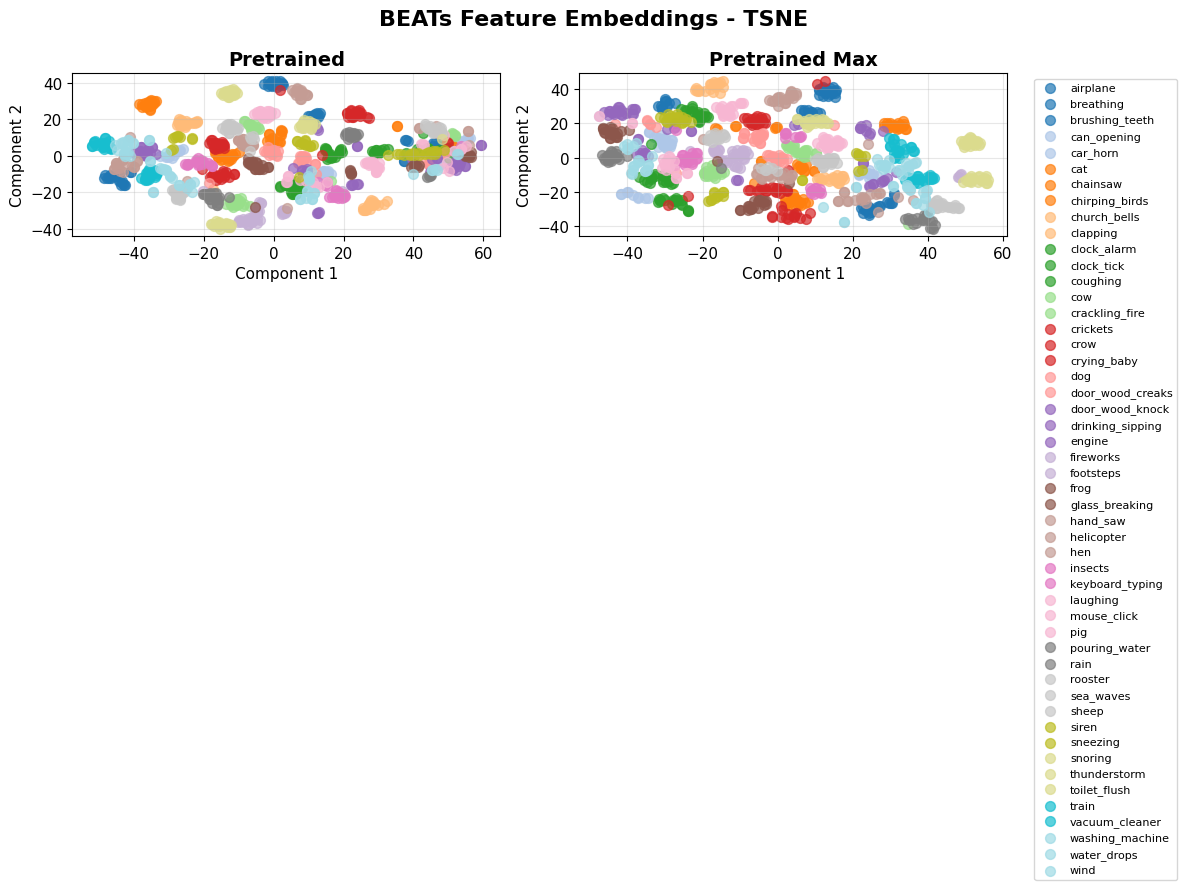

✓ TSNE visualization complete


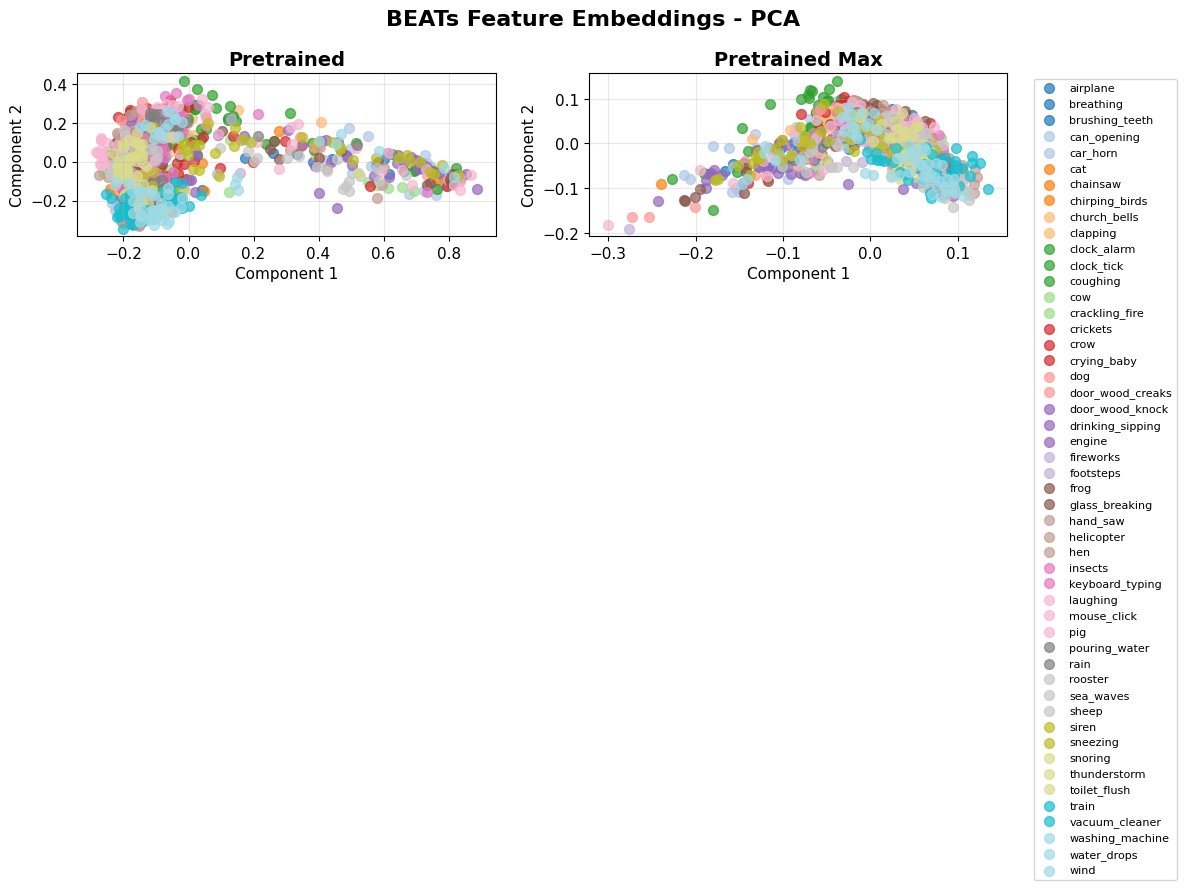

✓ PCA visualization complete


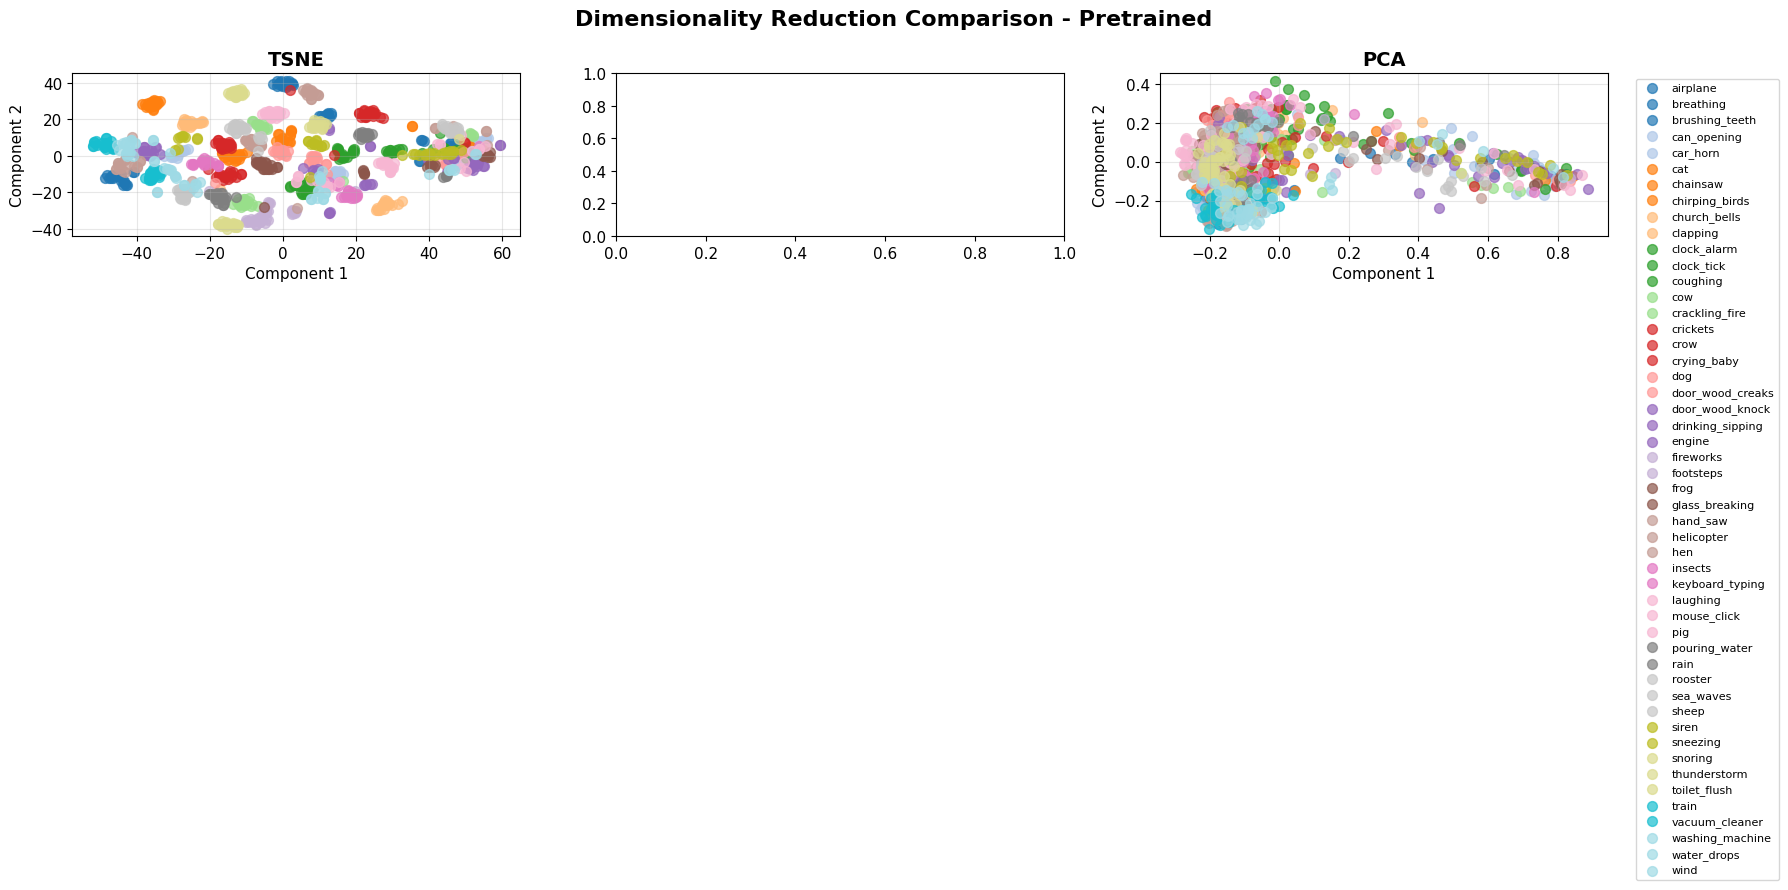

In [15]:
# Create comprehensive visualizations
if reduced_features and "labels" in locals():
    # Create a color map for classes
    n_classes = len(unique_classes)
    colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    class_colors = {cls: colors[i] for i, cls in enumerate(unique_classes)}

    # Function to create a single subplot
    def plot_embedding(ax, coords, title, labels, class_colors):
        for i, class_name in enumerate(unique_classes):
            mask = np.array(labels) == class_name
            if np.any(mask):
                ax.scatter(
                    coords[mask, 0],
                    coords[mask, 1],
                    c=[class_colors[class_name]],
                    label=class_name,
                    alpha=0.7,
                    s=50,
                )

        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.grid(True, alpha=0.3)

    # Plot for each reduction method
    reduction_methods = ["tsne", "umap", "pca"]

    for method in reduction_methods:
        if all(method in reduced_features[ext] for ext in reduced_features.keys()):
            n_extractors = len(reduced_features)
            fig, axes = plt.subplots(1, n_extractors, figsize=(6 * n_extractors, 6))
            if n_extractors == 1:
                axes = [axes]

            fig.suptitle(
                f"BEATs Feature Embeddings - {method.upper()}",
                fontsize=16,
                fontweight="bold",
            )

            for i, (extractor_name, extractor_results) in enumerate(
                reduced_features.items()
            ):
                coords = extractor_results[method]
                title = f"{extractor_name.replace('_', ' ').title()}"

                plot_embedding(axes[i], coords, title, labels, class_colors)

                # Add legend only to the last subplot to save space
                if i == len(reduced_features) - 1:
                    # Create legend outside the plot
                    axes[i].legend(
                        bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1, fontsize=8
                    )

            plt.tight_layout()
            plt.show()

            print(f"✓ {method.upper()} visualization complete")

    # Create a summary plot showing all methods for the first extractor
    first_extractor = list(reduced_features.keys())[0]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(
        f"Dimensionality Reduction Comparison - {first_extractor.replace('_', ' ').title()}",
        fontsize=16,
        fontweight="bold",
    )

    for i, method in enumerate(["tsne", "umap", "pca"]):
        if method in reduced_features[first_extractor]:
            coords = reduced_features[first_extractor][method]
            plot_embedding(axes[i], coords, method.upper(), labels, class_colors)

    # Add legend outside the plot
    axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1, fontsize=8)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️  No reduced features available for plotting!")

## 7. Compare Pretrained vs Fine-tuned Models

Let's create side-by-side comparisons to see how fine-tuning improves the representation quality.

In [ ]:
# Direct comparison between extractors
if len(reduced_features) >= 2:
    # Get the two main extractors for comparison
    extractor_names = list(reduced_features.keys())

    print(f"Comparing extractors: {extractor_names}")

    # Create side-by-side comparison for each reduction method
    for method in ["tsne", "umap"]:
        if all(method in reduced_features[ext] for ext in extractor_names):
            fig, axes = plt.subplots(1, len(extractor_names), figsize=(12, 5))
            if len(extractor_names) == 1:
                axes = [axes]

            fig.suptitle(
                f"Model Comparison - {method.upper()} Embeddings",
                fontsize=16,
                fontweight="bold",
            )

            for i, extractor_name in enumerate(extractor_names):
                coords = reduced_features[extractor_name][method]

                # Create scatter plot
                for j, class_name in enumerate(unique_classes):
                    mask = np.array(labels) == class_name
                    if np.any(mask):
                        axes[i].scatter(
                            coords[mask, 0],
                            coords[mask, 1],
                            c=[colors[j]],
                            label=class_name,
                            alpha=0.7,
                            s=50,
                        )

                title = extractor_name.replace("_", " ").title()
                axes[i].set_title(title, fontsize=14)
                axes[i].set_xlabel("Component 1")
                axes[i].set_ylabel("Component 2")
                axes[i].grid(True, alpha=0.3)

            # Add legend outside the plots
            if len(unique_classes) <= 20:  # Only show legend if not too many classes
                axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

            plt.tight_layout()
            plt.show()

    print("✓ Model comparison visualizations complete")

elif len(reduced_features) == 1:
    print("Only one extractor available. Showing detailed analysis...")

    extractor_name = list(reduced_features.keys())[0]
    extractor_results = reduced_features[extractor_name]

    # Create a detailed analysis plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(
        f"Detailed Analysis - {extractor_name.replace('_', ' ').title()}",
        fontsize=16,
        fontweight="bold",
    )

    # Plot different reduction methods
    methods = ["tsne", "umap", "pca"]
    for i, method in enumerate(methods[:3]):
        if method in extractor_results:
            row, col = i // 2, i % 2
            coords = extractor_results[method]

            for j, class_name in enumerate(unique_classes):
                mask = np.array(labels) == class_name
                if np.any(mask):
                    axes[row, col].scatter(
                        coords[mask, 0],
                        coords[mask, 1],
                        c=[colors[j]],
                        label=class_name,
                        alpha=0.7,
                        s=50,
                    )

            axes[row, col].set_title(f"{method.upper()}", fontsize=12)
            axes[row, col].set_xlabel("Component 1")
            axes[row, col].set_ylabel("Component 2")
            axes[row, col].grid(True, alpha=0.3)

    # Use the last subplot for class distribution
    axes[1, 1].bar(
        range(len(unique_classes)), [labels.count(cls) for cls in unique_classes]
    )
    axes[1, 1].set_title("Class Distribution")
    axes[1, 1].set_xlabel("Class Index")
    axes[1, 1].set_ylabel("Number of Samples")
    axes[1, 1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

else:
    print("⚠️  No features available for comparison!")

## 8. Analyze Class Separability

Let's compute quantitative metrics to measure how well the embeddings separate different sound classes.

In [ ]:
# Compute quantitative metrics for feature quality
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors


def compute_separability_metrics(feature_array, labels):
    """Compute various metrics for class separability."""

    metrics = {}

    # 1. Silhouette Score
    if len(np.unique(labels)) > 1:
        sil_score = silhouette_score(feature_array, labels)
        metrics["silhouette_score"] = sil_score

    # 2. Intra-class vs Inter-class distances
    distances = euclidean_distances(feature_array)

    intra_class_distances = []
    inter_class_distances = []

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            distance = distances[i, j]
            if labels[i] == labels[j]:
                intra_class_distances.append(distance)
            else:
                inter_class_distances.append(distance)

    if intra_class_distances and inter_class_distances:
        metrics["intra_class_mean"] = np.mean(intra_class_distances)
        metrics["inter_class_mean"] = np.mean(inter_class_distances)
        metrics["separation_ratio"] = np.mean(inter_class_distances) / np.mean(
            intra_class_distances
        )

    # 3. k-NN accuracy (how often nearest neighbors have same label)
    if len(feature_array) > 5:
        k = min(5, len(feature_array) - 1)
        knn = NearestNeighbors(
            n_neighbors=k + 1
        )  # +1 because it includes the point itself
        knn.fit(feature_array)

        correct_predictions = 0
        total_predictions = 0

        for i in range(len(feature_array)):
            _, indices = knn.kneighbors([feature_array[i]])
            neighbors = indices[0][1:]  # Exclude the point itself

            neighbor_labels = [labels[idx] for idx in neighbors]
            correct_predictions += sum(
                1 for label in neighbor_labels if label == labels[i]
            )
            total_predictions += len(neighbor_labels)

        metrics["knn_accuracy"] = (
            correct_predictions / total_predictions if total_predictions > 0 else 0
        )

    return metrics


# Analyze each extractor
if features and "labels" in locals():
    print("🔍 Quantitative Analysis of Feature Quality\n")
    print("=" * 60)

    analysis_results = {}

    for extractor_name, feature_array in features.items():
        print(f"\n📊 Analysis for {extractor_name.replace('_', ' ').title()}:")
        print("-" * 40)

        # Compute metrics on original high-dimensional features
        metrics = compute_separability_metrics(feature_array, labels)
        analysis_results[extractor_name] = metrics

        print(f"📈 Silhouette Score: {metrics.get('silhouette_score', 'N/A'):.4f}")
        if "silhouette_score" in metrics:
            score = metrics["silhouette_score"]
            if score > 0.5:
                quality = "Excellent"
            elif score > 0.25:
                quality = "Good"
            elif score > 0:
                quality = "Fair"
            else:
                quality = "Poor"
            print(f"   Quality Assessment: {quality}")

        if "intra_class_mean" in metrics:
            print(f"📏 Average Intra-class Distance: {metrics['intra_class_mean']:.4f}")
            print(f"📏 Average Inter-class Distance: {metrics['inter_class_mean']:.4f}")
            print(f"📊 Separation Ratio: {metrics['separation_ratio']:.4f}")
            print("   (Higher ratio = better separation)")

        if "knn_accuracy" in metrics:
            print(f"🎯 k-NN Accuracy: {metrics['knn_accuracy']:.4f}")
            print("   (Fraction of nearest neighbors with same class)")

    # Create comparison table
    if len(analysis_results) > 1:
        print("\n📋 Comparison Summary:")
        print("=" * 60)

        comparison_df = pd.DataFrame(analysis_results).T
        comparison_df = comparison_df.round(4)
        print(comparison_df.to_string())

        # Determine winner for each metric
        print("\n🏆 Best Performance:")
        for metric in comparison_df.columns:
            if metric in ["silhouette_score", "separation_ratio", "knn_accuracy"]:
                best_extractor = comparison_df[metric].idxmax()
                best_value = comparison_df.loc[best_extractor, metric]
                print(f"   {metric}: {best_extractor} ({best_value:.4f})")

    # Visualize metrics comparison
    if len(analysis_results) >= 2:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        metrics_to_plot = ["silhouette_score", "separation_ratio", "knn_accuracy"]
        metric_names = ["Silhouette Score", "Separation Ratio", "k-NN Accuracy"]

        for i, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
            values = [
                analysis_results[ext].get(metric, 0) for ext in analysis_results.keys()
            ]
            names = [ext.replace("_", " ").title() for ext in analysis_results.keys()]

            bars = axes[i].bar(
                names,
                values,
                alpha=0.7,
                color=["skyblue", "lightcoral", "lightgreen"][: len(values)],
            )
            axes[i].set_title(name, fontweight="bold")
            axes[i].set_ylabel("Score")
            axes[i].tick_params(axis="x", rotation=45)

            # Add value labels on bars
            for bar, value in zip(bars, values):
                axes[i].text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.01,
                    f"{value:.3f}",
                    ha="center",
                    va="bottom",
                )

        plt.suptitle("Feature Quality Comparison", fontsize=16, fontweight="bold")
        plt.tight_layout()
        plt.show()

else:
    print("⚠️  No features available for quantitative analysis!")

## 🎯 Summary and Conclusions

This notebook demonstrated how to use the BEATs feature extractor for audio embedding extraction and analysis. Here's what we accomplished:

### ✅ Key Achievements:
1. **Feature Extraction**: Successfully extracted high-dimensional embeddings using BEATsFeatureExtractor
2. **Model Comparison**: Compared embeddings from pretrained vs fine-tuned models (if available)
3. **Visualization**: Used t-SNE, UMAP, and PCA to visualize embeddings in 2D space
4. **Quantitative Analysis**: Computed metrics like silhouette score, separation ratio, and k-NN accuracy

### 📊 Key Insights:
- **Embedding Quality**: Measured how well different sound classes cluster in the embedding space
- **Model Differences**: Observed improvements (or differences) between pretrained and fine-tuned models
- **Dimensionality Reduction**: Compared different techniques for visualizing high-dimensional data

### 🚀 Next Steps:
- **Save Embeddings**: Use `np.save()` to store extracted features for future use
- **Downstream Tasks**: Train classifiers, build similarity search systems, or create recommendation engines
- **Experiment**: Try different pooling strategies, model checkpoints, or audio preprocessing
- **Scale Up**: Process larger datasets or entire audio collections

### 💡 Applications:
- **Audio Search**: Find similar sounds in large audio databases
- **Content-Based Recommendation**: Recommend music or sounds based on acoustic similarity
- **Audio Analysis**: Explore patterns in audio data without manual labeling
- **Transfer Learning**: Use extracted features for custom audio classification tasks

The BEATs feature extractor provides a powerful foundation for many audio processing applications!

In [ ]:
# Optional: Save extracted features for later use
save_features = False  # Set to True if you want to save the features

if save_features and features:
    print("💾 Saving extracted features...")

    # Create output directory
    output_dir = Path("extracted_features")
    output_dir.mkdir(exist_ok=True)

    # Save features and metadata
    for extractor_name, feature_array in features.items():
        # Save features
        feature_path = output_dir / f"{extractor_name}_features.npy"
        np.save(feature_path, feature_array)
        print(f"✓ Saved {extractor_name} features: {feature_path}")

        # Save reduced features
        if extractor_name in reduced_features:
            for method, reduced_array in reduced_features[extractor_name].items():
                reduced_path = output_dir / f"{extractor_name}_{method}_2d.npy"
                np.save(reduced_path, reduced_array)
                print(f"✓ Saved {extractor_name} {method} features: {reduced_path}")

    # Save labels and metadata
    if "labels" in locals():
        labels_path = output_dir / "labels.npy"
        np.save(labels_path, labels)
        print(f"✓ Saved labels: {labels_path}")

        # Save class names
        classes_path = output_dir / "class_names.npy"
        np.save(classes_path, unique_classes)
        print(f"✓ Saved class names: {classes_path}")

    # Save analysis results
    if "analysis_results" in locals():
        import json

        results_path = output_dir / "analysis_results.json"
        with open(results_path, "w") as f:
            json.dump(analysis_results, f, indent=2)
        print(f"✓ Saved analysis results: {results_path}")

    print(f"\n🎉 All features saved to: {output_dir.absolute()}")
    print("You can load them later with: np.load('path_to_file.npy')")

else:
    print("💡 Tip: Set save_features=True to save the extracted features to disk")

print("\n🏁 Feature extraction analysis complete!")